In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import argparse
import csv
import torch.nn.parallel
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import PIL
import glob

In [2]:
gpu = 0
batch_size = 32
max_epoch = 10

In [3]:
class victorianDataset(Dataset):
    def __init__(self, root, transforms_=None):
        self.transform = transforms.Compose(transforms_)

        self.gray_files = sorted(glob.glob(os.path.join(root, 'gray') + "/*.*"))
        self.color_files = sorted(glob.glob(os.path.join(root, 'resized') + "/*.*"))
     
    def __getitem__(self, index):

        gray_img = Image.open(self.gray_files[index % len(self.gray_files)]).convert("RGB")
        color_img = Image.open(self.color_files[index % len(self.color_files)]).convert("RGB")
    
        gray_img = self.transform(gray_img)
        color_img = self.transform(color_img)

        return {"A": gray_img, "B": color_img}

    def __len__(self):
        return len(self.gray_files)


In [4]:
root = 'C:/Users/a/OneDrive - 고려대학교/PseudoLab/GANdataset/victorian/'
img_height = 256
img_width = 256

In [5]:
transforms_ = [
    # transforms.Resize((img_height, img_width), Image.BICUBIC),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
]


train_loader = DataLoader(
    victorianDataset(root, transforms_=transforms_),
    batch_size=batch_size,
    shuffle=True
)

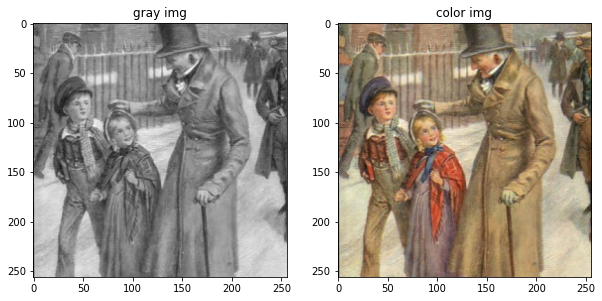

In [6]:
fig = plt.figure(figsize=(10, 5))
rows = 1 
cols = 2

for X in train_loader:
    
    ax1 = fig.add_subplot(rows, cols, 1)
    ax1.imshow(np.clip(np.transpose(X["A"][0], (1,2,0)), 0, 1))
    ax1.set_title('gray img')

    ax2 = fig.add_subplot(rows, cols, 2)
    ax2.imshow(np.clip(np.transpose(X["B"][0], (1,2,0)), 0, 1))
    ax2.set_title('color img')    

    plt.show()
    break

In [7]:
test_root = root + 'test/'
test_batch_size = 6

test_loader = DataLoader(
    victorianDataset(test_root, transforms_=transforms_),
    batch_size=test_batch_size,
    shuffle=True
)

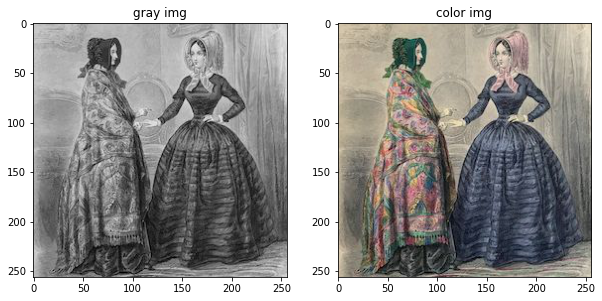

In [8]:
fig = plt.figure(figsize=(10, 5))
rows = 1 
cols = 2

for X in test_loader:
    
    ax1 = fig.add_subplot(rows, cols, 1)
    ax1.imshow(np.clip(np.transpose(X["A"][0], (1,2,0)), 0, 1))
    ax1.set_title('gray img')

    ax2 = fig.add_subplot(rows, cols, 2)
    ax2.imshow(np.clip(np.transpose(X["B"][0], (1,2,0)), 0, 1))
    ax2.set_title('color img')    

    plt.show()
    break

In [9]:
def imshow(inp):
    inp = inp.numpy().transpose((1,2,0))
    print(inp.shape)
    inp = np.clip(inp, 0, 1) 
    plt.imshow(inp)

In [10]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        """noise image + gray image"""
        # batch_size * 2 * 64 * 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(2, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1)
        )
        
        # batch_size * 64 * 64 * 64
        self.maxpool = nn.MaxPool2d(2,2)
        
        # batch_size * 64 * 32 * 32
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64 * 2 , 3, 1, 1),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.1)
        )
        
        # batch_size * (64 * 2) * 32 * 32
        # maxpool(2,2)
        
        # batch_size * (64 * 2) * 16 * 16
        self.conv3 = nn.Sequential(
            nn.Conv2d(64*2, 64 * 4, 3, 1, 1),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.1)
        )
        
        # batch_size * (64 * 4) * 16 * 16
        # maxpool(2,2)
        
        # batch_size * (64 * 4) * 8 * 8
        self.conv4 = nn.Sequential(
            nn.Conv2d(64 * 4, 64 * 8, 8, 1, 0),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.1)
        )
        
        # batch_size * (64 * 8) * 1 * 1
        self.fc = nn.ConvTranspose2d(64 * 8, 64 * 16, 4, 1, 0)
        
        # batch_size * (64 * 16) * 4 * 4
        self.upsample1 = nn.Sequential(
            nn.ConvTranspose2d(64 * 16, 64 * 8, 4, 2, 1),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.1)
        )
        
        # batch_size * (64 * 8) * 8 * 8
        self.upsample2 = nn.Sequential(
            nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.1)
        )
        
        # batch_size * (64 * 4) * 16 * 16
        self.upsample3 = nn.Sequential(
            nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1),
            nn.BatchNorm2d(64 *2),
            nn.LeakyReLU(0.1)
        )
        
        # batch_size * (64 * 2) * 32 * 32        
        self.upsample4 = nn.Sequential(
            nn.ConvTranspose2d(64 * 2, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2)
        )
        
        # batch_size * 64 * 64 * 64
        self.conv1by1 = nn.Sequential(
            nn.Conv2d(64,64,1,1,0),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1)
        )
        
        
        # batch_size * 64 * 64 * 64
        self.conv = nn.Sequential(
            nn.Conv2d(64, 3, 3, 1, 1),
            nn.Tanh()
        )
        # batch_size * 3 * 64 * 64

    def forward(self, input):
        output1 = self.conv1(input)
        pool1 = self.maxpool(output1)
        output2 = self.conv2(pool1)
        pool2 = self.maxpool(output2)
        output3 = self.conv3(pool2)
        pool3 = self.maxpool(output3)
        output4 = self.conv4(pool3)
        output5 = self.fc(output4)
        output6 = self.upsample1(output5)
        output7 = self.upsample2(output6) + output3
        output8 = self.upsample3(output7) + output2
        output9 = self.upsample4(output8) + output1
        output10 = self.conv1by1(output9)
        out = self.conv(output10)
        
        return out

In [11]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            #""" color imgage (fake or real image)"""
            # batch_size * 3 * 64 * 64
            nn.Conv2d(3,64,kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.LeakyReLU(0.2, inplace = True),
            
            # batch_size * 64 * 32 * 32
            nn.Conv2d(64,128,kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace = True),
            
            # batch _size * 64 * 32 * 32
            nn.Conv2d(128, 128, kernel_size = 1, stride = 1, padding = 0, bias = False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace = True),
            
            # batch_size * 128 * 16 * 16
            nn.Conv2d(128, 256, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace = True),
            
            # batch_size * 256 * 8 * 8
            nn.Conv2d(256, 512, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace = True),
            
            # batch_size * 512 * 4 * 4
            nn.Conv2d(512, 1024, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace = True),
            
            # batch_size * 1024 * 2 * 2
            )
        
        
        # batch_size * 1024 * 2 * 2
        self.fc = nn.Sequential(
            nn.Linear(1024 * 2 * 2 , 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, batch_size),
            nn.Sigmoid()
        )
        
    def forward(self, input, b_size):
        output = self.main(input)
        output = self.fc(output.view(b_size,-1))
        return output

In [12]:
def to_variable(x):
    if torch.cuda.is_available:
        x = x.cuda(gpu)
    return Variable(x)

In [13]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:         # Conv weight init
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:  # BatchNorm weight init
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [14]:
Discri = Discriminator().cuda(gpu) if torch.cuda.is_available() else Discriminator()
Discri.apply(weights_init)
Gener = Generator().cuda(gpu) if torch.cuda.is_available() else Generator()
Gener.apply(weights_init)

Generator(
  (conv1): Sequential(
    (0): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(8, 8), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope

In [15]:
real_label = 1
fake_label = 0

In [16]:
Loss= nn.BCELoss().cuda(gpu) if torch.cuda.is_available() else nn.BCELoss()
optimizerD = torch.optim.Adam(Discri.parameters(), lr = 0.0002,betas = (0.5, 0.999))
optimizerG = torch.optim.Adam(Gener.parameters(), lr = 0.0002, betas = (0.5, 0.999))

[5,    13] real loss: 0.3164, fake_loss : 0.2112, g_loss : 0.2932
(134, 530, 3)


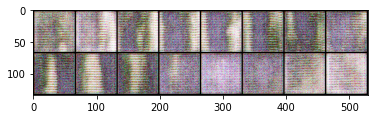

[10,    13] real loss: 0.2739, fake_loss : 0.2390, g_loss : 0.2418
(134, 530, 3)


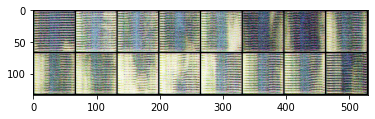

In [17]:
for epoch in range(max_epoch):
    loss_D = 0.0
    for i, data in enumerate(train_loader):
        gray, color = data['A'], data['B']
        # print(len(data['A']))
        b_size = len(data['A'])

        color = torch.from_numpy(np.resize(color.numpy(), (b_size, 3, 64, 64))) 
        # gray >> grays (batch_size * 1 * 64 * 64)
        grays = torch.from_numpy(np.resize(gray.numpy(), (b_size, 1, 64, 64)))
        
        ######## Train Discriminator ########
        
        color = to_variable(color)
        # Make noise
        noise = torch.randn(b_size, 1, 64, 64).uniform_(0,1)
 
        # gray image + noise image
        gray_noise = to_variable(torch.cat([grays,noise],dim=1))
        #print(gray_noise.shape)
        
        ####### Train d to recognize color image as real

        # print("color : ", color.shape)
        # print('b_size : ', b_size)
        output = Discri(color,b_size)
        real_loss = torch.mean((output-1)**2)
        
        ###### Train d to recognize fake image as fake
        
        fake_img = Gener(gray_noise)
        # print("fake_img : ", fake_img.shape)
        # print('b_size : ', b_size.shape)
        output = Discri(fake_img,b_size)
        fake_loss = torch.mean(output**2)
        
        ###### Backpro & Optim D
        d_loss = real_loss + fake_loss
        Discri.zero_grad()
        Gener.zero_grad()
        d_loss.backward()
        optimizerD.step()
        
        
        ######## Train Generator ########
        noise = torch.randn(b_size, 1, 64, 64).uniform_(0,1)
        gray_noise2 = to_variable(torch.cat([grays,noise],dim=1))
        fake_img = Gener(gray_noise2)
        output = Discri(fake_img,b_size)
        g_loss = torch.mean((output-1)**2)
        
        ###### Backpro & Optim G
        Discri.zero_grad()
        Gener.zero_grad()
        g_loss.backward()
        optimizerG.step()
        
        
        #print(fake.shape)
        fake_img = torchvision.utils.make_grid(fake_img.data)

    if (epoch + 1) % 5 == 0:
        print('[%d, %5d] real loss: %.4f, fake_loss : %.4f, g_loss : %.4f' % (epoch + 1, i+1, real_loss.item(),fake_loss.item(), g_loss.item()))
        imshow(fake_img.cpu())
        plt.show()

torch.Size([6, 1, 64, 64])
======inputs======
(68, 398, 3)


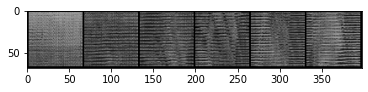

======origin======
(260, 1550, 3)


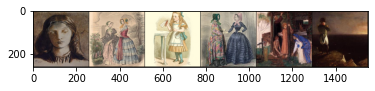

======output======
(68, 398, 3)


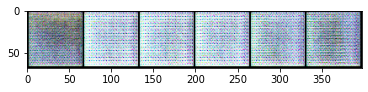

In [18]:
Discri.eval()
Gener.eval()

fixed_noise = torch.randn(test_batch_size, 1, 64, 64).uniform_(0,1)

for i, data in enumerate(test_loader,0) :
    images, label = data['A'], data['B']

    if len(data['A']) != test_batch_size:
        continue

    grays = torch.from_numpy(np.resize(images.numpy(), (test_batch_size, 1, 64, 64)))
    print(grays.shape)
    
    gray = to_variable(torch.cat([grays,fixed_noise],dim = 1))
    
    output = Gener(gray)
    inputs = torchvision.utils.make_grid(grays)
    labels = torchvision.utils.make_grid(label)
    out = torchvision.utils.make_grid(output.data)
    print('======inputs======')
    imshow(inputs.cpu())
    plt.show()
    print('======origin======')
    imshow(labels.cpu())
    plt.show()
    print('======output======')
    imshow(out.cpu())
    plt.show()